In [237]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mutual_info_score
import scipy.stats as stats
import pandas as pd
import numpy as np
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("../frontal_lobe.csv").iloc[:,2:]

In [308]:
def BIC(X, y, penalty=1.0):
    """ X is the set of variables in the model that might be parents of y, y is the variable
    we are checking against"""
    
    if len(X.shape) < 2:
        X = X.reshape(-1, 1)

    if X.shape[1] == 0:
        return 0
    regression = LinearRegression().fit(X, y)
    y_predicted = regression.predict(X)
    residuals = y - y_predicted
    n, k = X.shape
    mean_sq_error = np.sum(np.square(residuals))/n
    BIC_score = -n*np.log(mean_sq_error) - penalty*k*np.log(n)

    return BIC_score

The penalty parameter only offers a meaningful reduction in the search of
Markov Blankets if it makes the penalty be in the same order of magnitude
as the log likelihood term. If it's too small, all variables are important
If it's too big, all variables can be neglected. 
This says something about the structure of the net (small contributions from various components)

It should be chosen so that k*log(n)*penalty ~ n

In [543]:
class FGES:
    def __init__(self, data, penalty=1.0):
        self.data = data.values
        n = len(data.columns)
        self.nodes = list(range(n))
        
        # Keep dictionaries with all children, parents and undirected edges for each node
        self.children = {node: set() for node in self.nodes}
        self.undirected = {node: set() for node in self.nodes}
        self.parents = {node: set() for node in self.nodes}
        self.adjacencies = {node: set() for node in self.nodes}
        
        # Each column is, given the parents of this node, add the node in the row.
        self.BICS = np.zeros((n, n))
        self.penalty = penalty
        self.init_BICS()
        
        # Add set of arrows
        self.arrows = [((i,j), set(), set(), self.BICS[i, j]) for i in range(n) for j in range(n) if self.BICS[i, j] > 0]
        self.arrows.sort(key=lambda x: x[3], reverse=True)
        

    def draw_net(self):
        # Draw to check
        labels={}
        for node in self.nodes:
            labels[node] = r'$'+str(node)+'$'
        BN = nx.DiGraph()
        edges = [(key, value) for key, values in list(self.children.items())+list(self.undirected.items()) for value in values]
        BN.add_edges_from(edges)
        BN.add_nodes_from(list(self.nodes))
        pos=nx.spring_layout(BN)
        nx.draw(BN, pos)
        nx.draw_networkx_labels(BN,pos,labels,font_size=16)
        plt.show()


    def BIC(self, X, y):
        return BIC(X, y, self.penalty)
    
    def apply_meek_rules(self, node_set=None):
        # Apply Meek's rules to the graph to direct some of the edges.
        # Check if any changes happen
        changes = set()
        
        if not(node_set):
            node_set = self.nodes
        for node in node_set:
            prev_children = self.children[node].copy()
            for adj in prev_children:
                # Rule 1: Away from collider
                prev_undirected = self.undirected[adj].copy()
                for double_adj in prev_undirected:
                    if not(double_adj in self.adjacencies[node]):
                        self.undirected[double_adj].remove(adj)
                        self.undirected[adj].remove(double_adj)
                        self.children[adj].add(double_adj)
                        self.parents[double_adj].add(adj)
                    changes.add(double_adj)
                    changes.add(adj)

                # Rule 2: Away from cycle
                prev_adj_children = self.children[adj].copy()
                for double_adj in prev_adj_children:
                    if double_adj in self.undirected[node]:
                        self.undirected[double_adj].remove(node)
                        self.undirected[node].remove(double_adj)
                        self.children[node].add(double_adj)
                        self.parents[double_adj].add(node)
                        changes.add(double_adj)
                        changes.add(adj)

            # Rule 3: Double triangle
            prev_undirected = self.undirected[node].copy()
            for adj in prev_undirected:
                prev_adj_undirected = self.undirected[adj].copy()
                for double_adj in prev_adj_undirected:
                    mutuals = self.children[node] & self.undirected[adj] & self.children[double_adj]
                    for target in mutuals:   
                        self.undirected[target].remove(adj)
                        self.undirected[adj].remove(target)
                        self.parents[target].add(adj)
                        self.children[adj].add(target)
                        changes.add(target)
                        changes.add(adj)
        return changes


    def CPDAG(self, node_set=None):
        # Eliminate all directions from edges except on v-structures.
        # Keep track of changes
        changes = set()
        
        if not(node_set):
            node_set = self.nodes

        for node in node_set:
            prev_children = self.children[node].copy()
            for adj in prev_children:
                v_struct = False
                prev_parents = self.parents[adj] - {node}
                for double_adj in prev_parents:
                    if not(double_adj in self.adjacencies[node]):
                        v_struct = True
                        break
                    else:
                        continue
                if not v_struct:
                    self.undirected[adj].add(node)
                    self.undirected[node].add(adj)
                    self.parents[adj].remove(node)
                    self.children[node].remove(adj)
                    changes.add(adj)
                    changes.add(node)
        return changes
    
    def local_meek(self, node_set):
        print("Pre Meek")
        self.draw_net()
        changes = self.CPDAG(node_set)
        node_set = node_set.union(changes)
        changes = self.apply_meek_rules(node_set)
        changes_past = set()
        while (changes != set()):
            changes = self.CPDAG(changes).union(self.apply_meek_rules(changes))
            node_set = node_set.union(changes)
            changes_past = changes.copy()
            
        print("Post Meek")
        self.draw_net()
        return node_set


    def init_BICS(self):
        n = len(self.nodes)
        for i in range(n):
            y = self.data[:, i]
            for j in range(i+1, n):
                X = self.data[:, j]
                self.BICS[i, j] = self.BIC(X, y)
                self.BICS[j, i] = self.BICS[i, j]


    def check_clique(self, node_set):
        # Check if a subgraph is fully connected.
        for node in node_set:
            if self.adjacencies[node] < node_set:
                return False
        return True


    def parts_of(self, node_set):
        # Return an iterator over all the subsets of a given set.
        for size in range(len(node_set)+1):
            yield from combinations(node_set, size)

            
    def calculate_arrows_forward(self, x, y):
        # This checks all possible edge additions to y from x depending on the adjacent nodes.
        # Then adds them to the list of arrows if they are valid and with positive score.
        # Not sure why we do it this way

        T = self.adjacencies[y] - self.adjacencies[x]
        NaYX = self.adjacencies[y] & self.undirected[x]
        for subset in self.parts_of(T):
            S = NaYX.union(set(subset))
            if self.check_clique(S):
                S = S.union(self.parents[y])
                data_y = self.data[:, y].reshape(self.data.shape[0], -1)
                X_0 = self.data[:, list(S)].reshape(self.data.shape[0], -1)
                X = self.data[:, list(S)+[x]].reshape(self.data.shape[0], -1)
                b = self.BIC(X, data_y) - self.BIC(X_0, data_y)
                if b > 0:
                    self.arrows.append(((x,y), NaYX, T, b))
                    self.arrows.sort(key=lambda x: x[3], reverse=True)
                              

    def reevaluate_forward(self, node_set):
        # Recalculate all possible edge additions towards every node in the node set.
        for node in node_set:
            for other in (j for j in range(len(self.nodes)) if self.BICS[j, node] > 0):
                self.arrows = [arrow for arrow in self.arrows if arrow[0] != (other, node)]
                self.calculate_arrows_forward(other, node)


    def check_arrow(self, arrow):
        x, y = arrow[0]
        NaYX, T = arrow[1:3]
        if not(y in self.adjacencies[x]):
            if NaYX == (self.adjacencies[y] & self.undirected[x]):
                if T <= (self.undirected[y] - self.adjacencies[x]):
                    return True
        return False
            

    def forward_equivalence_search(self):
        while self.arrows != []:
            
            best_edge = self.arrows.pop(0)

            x, y = best_edge[0]
            NaYX, T = best_edge[1:3]
            if self.check_arrow(best_edge) and self.check_clique(NaYX.union(T)):
                # Add edge
                self.parents[y].add(x)
                self.children[x].add(y)
                self.adjacencies[x].add(y)
                self.adjacencies[y].add(x)
                # Orient every node on T into y
                for node in T:
                    self.parents[y].add(node)
                    self.children[node].add(y)
                    self.undirected[node].remove(y)
                    self.undirected[y].remove(node)
                
                # Undirect all nodes except unshielded colliders
                node_set = self.local_meek({x, y})
                self.reevaluate_forward(node_set)
                              
                              
                              
    def init_BICS_deletion(self):
        n = len(self.nodes)
        self.BICS = np.zeros((n, n))
        for node in self.nodes:
            Adj = list(self.edges[node])
            if not Adj:
                continue
                
            y = self.data[:, node]
            data_n = self.data[:, Adj]
            start_BIC = self.BIC(data_n, y)
            if len(Adj) <= 1:
                continue
            for edge in Adj:
                data_n = self.data[:, tuple(set(Adj)-{edge})]
                self.BICS[edge, node] = self.BIC(data_n, y) - start_BIC
            
    def backward_equivalence_search(self):
        # Initialize BIC matrix for deletion.
        
        
        j, i = np.unravel_index(np.argmax(self.BICS), self.BICS.shape)
        self.edges[i].remove(j)
        self.parents[i].remove(i)

        
        Adj = list(self.edges[i])
        y = self.data[:, i]
        data_n = self.data[:, Adj]
        start_BIC = self.BIC(data_n, y)
        
        for edge in Adj:
            X = self.data[:, tuple(set(Adj)-{edge})]
            self.BICS[edge, i] = self.BIC(data_n, y) - start_BIC
            self.BICS[i, edge] = self.BICS[edge, i]
        
        self.BICS[j, i], self.BICS[i, j] = 0, 0
        self.CPDAG()
        self.apply_meek_rules()
        return True
        
        

In [551]:
%%time
test = FGES(data.iloc[:, :6], penalty=60.0)

CPU times: user 55.9 ms, sys: 4.06 ms, total: 59.9 ms
Wall time: 11 ms


Pre Meek


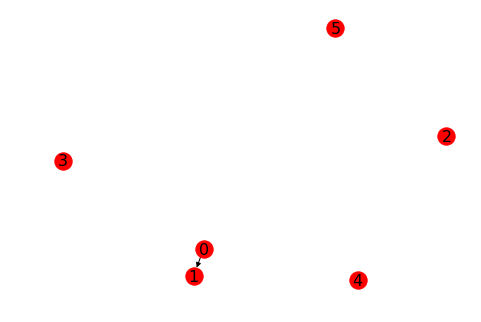

Post Meek


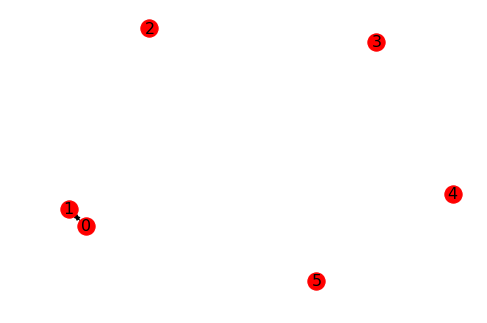

Pre Meek


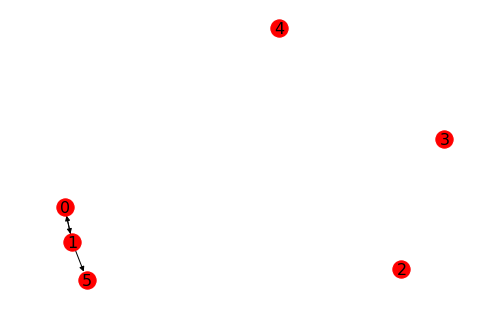

Post Meek


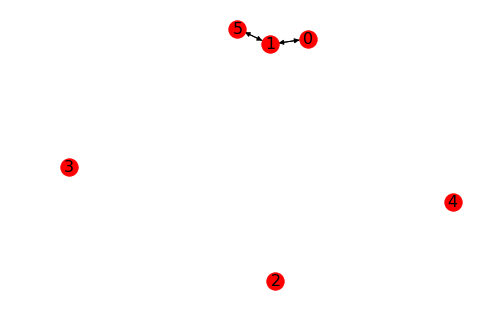

Pre Meek


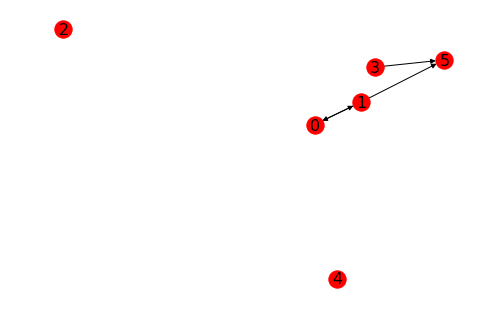

Post Meek


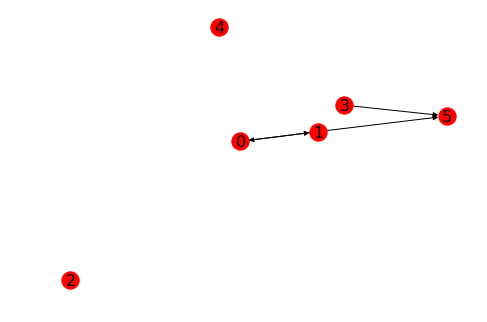

Pre Meek


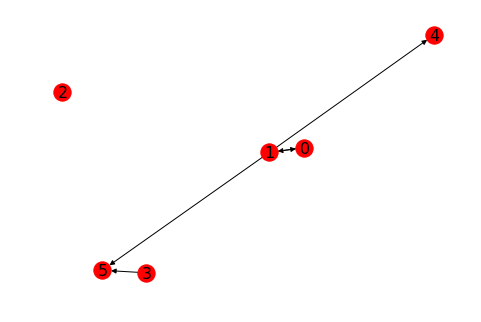

Post Meek


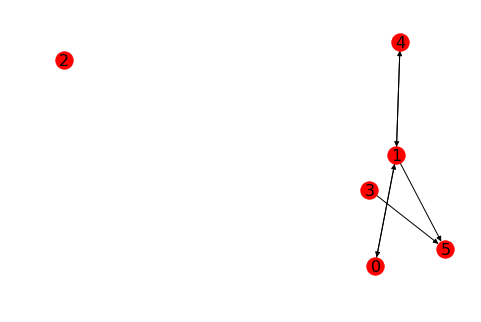

Pre Meek


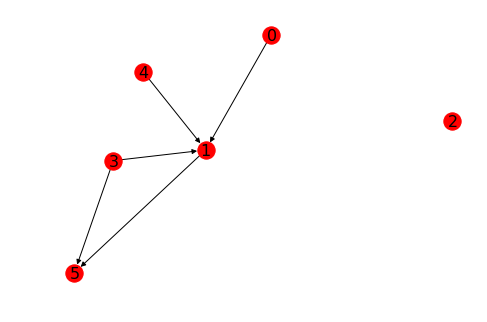

Post Meek


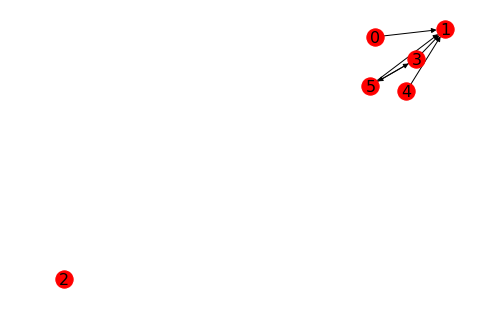

Pre Meek


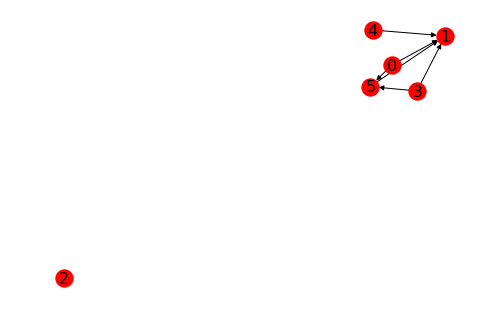

Post Meek


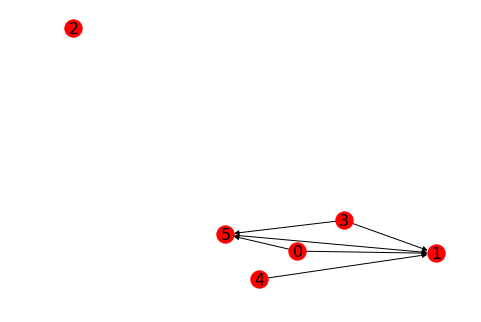

Pre Meek


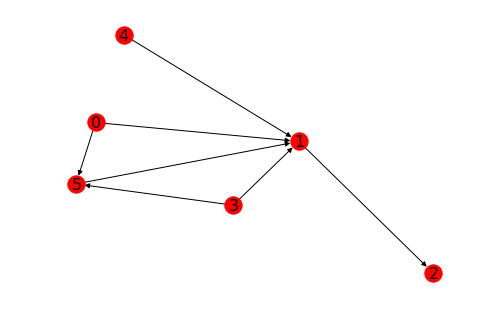

Post Meek


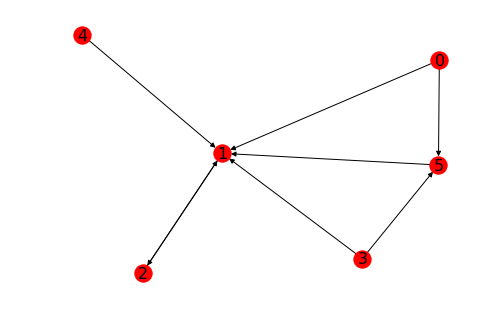

Pre Meek


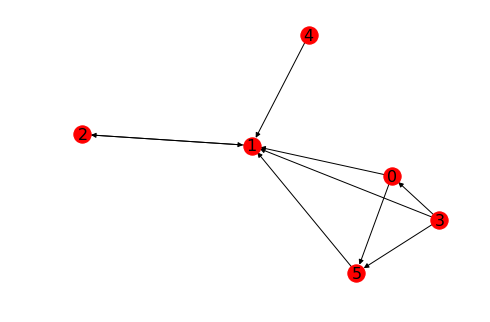

Post Meek


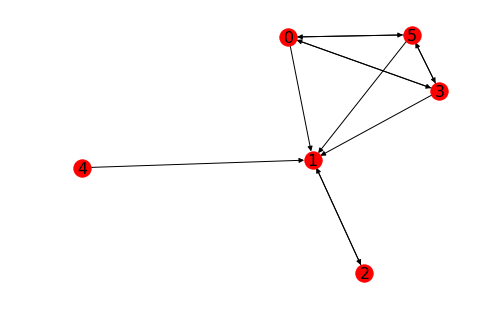

Pre Meek


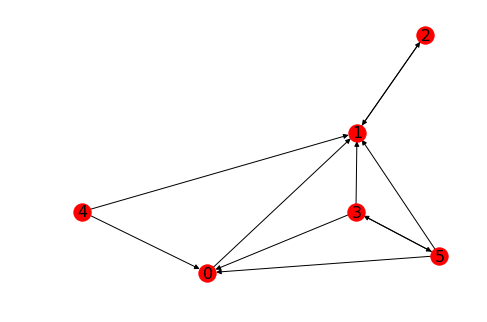

Post Meek


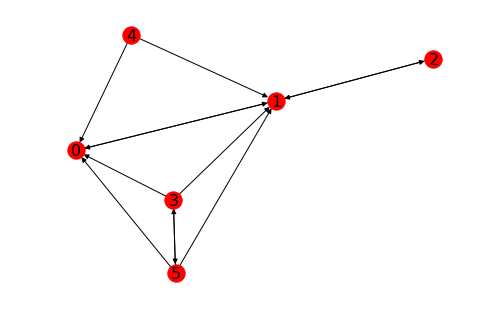

Pre Meek


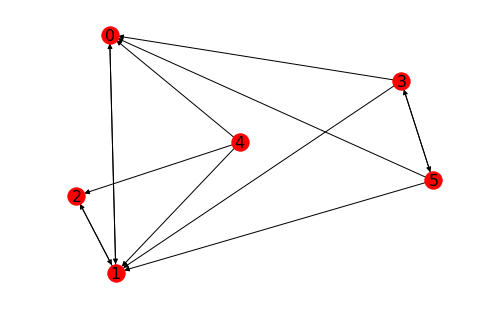

Post Meek


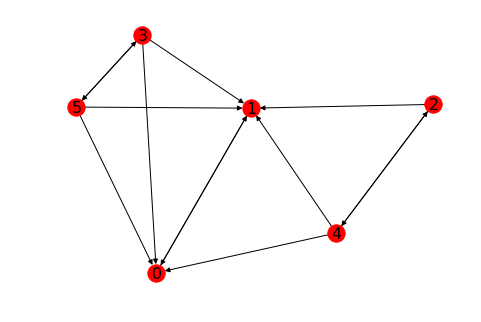

Pre Meek


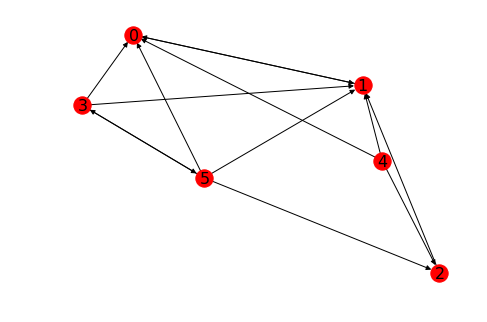

Post Meek


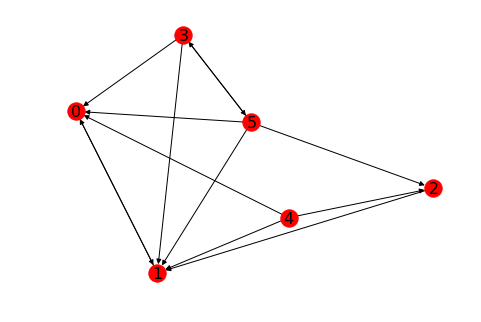

CPU times: user 16.8 s, sys: 834 ms, total: 17.7 s
Wall time: 3.83 s


In [552]:
%%time
test.forward_equivalence_search()

In [549]:
test.undirected

{0: {1, 2, 3, 4, 5},
 1: {0, 2, 3, 4, 5},
 2: {0, 1, 3, 4},
 3: {0, 1, 2, 4, 5},
 4: {0, 1, 2, 3, 5},
 5: {0, 1, 3, 4}}

In [550]:
for n in test.nodes:
    print(n, ": ", test.parents[n] & test.children[n])

0 :  set()
1 :  set()
2 :  set()
3 :  set()
4 :  set()
5 :  set()


In [513]:
test.parents

{0: set(),
 1: set(),
 2: {7, 8},
 3: set(),
 4: set(),
 5: {7, 8},
 6: set(),
 7: set(),
 8: {3, 6, 9},
 9: set()}

In [514]:
BN = nx.DiGraph()
edges = [(key, value) for key, values in list(test.children.items()) for value in values]
BN.add_edges_from(edges)

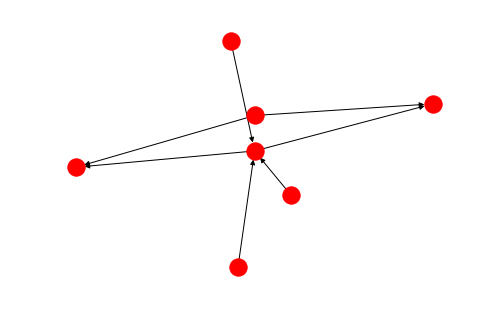

In [515]:
import matplotlib.pyplot as plt
nx.draw(BN)
plt.show()

NetworkXError: nbunch is not a node or a sequence of nodes.

In [210]:
test.CPDAG()

starter:  0
v on:  1
Start looking
{0}
Second parent:  0
True
v on:  2
Start looking
{0}
Second parent:  0
True
v on:  4
Start looking
{0, 2, 3}
Second parent:  0
True
Second parent:  2
True
Second parent:  3
False
v struct
starter:  1
v on:  0
v on:  3
Start looking
{1}
Second parent:  1
True
starter:  2
v on:  0
v on:  4
Start looking
{0, 2, 3}
Second parent:  0
True
Second parent:  2
True
Second parent:  3
False
v struct
starter:  3
v on:  1
v on:  4
Start looking
{0, 2, 3}
Second parent:  0
False
v struct
starter:  4


In [212]:
test.apply_meek_rules()
test.edges

{0: {1, 2, 4}, 1: {0, 3}, 2: {0, 4}, 3: {1, 4}, 4: set()}

In [90]:
%%time
residuals = np.linalg.lstsq(np.c_[X, np.ones_like(X)], y)[1]



CPU times: user 4.29 ms, sys: 256 µs, total: 4.55 ms
Wall time: 1.46 ms


/home/cig/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [92]:
%%time
regression = LinearRegression().fit(X, y)
y_predicted = regression.predict(X)
residuals = y - y_predicted
n, k = X.shape
mean_sq_error = np.sum(np.square(residuals))/n
BIC_score = -n*np.log(mean_sq_error) - 60*k*np.log(n)

CPU times: user 4.43 ms, sys: 25 µs, total: 4.45 ms
Wall time: 1.67 ms


(2, 537, 10)


LinAlgError: Incompatible dimensions